# <img src="./assets/anpl_solo_logo.png" style="height:50px;display:inline"> DDS 0970252 - Autonomous Planning Under Uncertainty
---

**Moshe Rafaeli** - [moshiktech@gmail.com](mailto:moshiktech@gmail.com) \
**Tamir Shazman** - [tmyr@campus.technion.ac.il](mailto:tmyr@campus.technion.ac.il)

Course website: https://anpl-technion.github.io/Teaching/#POMDP \
Course forum and announcements: https://piazza.com/technion.ac.il/fall2025/0970252


## <img width="48" height="48" src="https://img.icons8.com/external-vectorslab-outline-color-vectorslab/53/external-51-science-and-experiments-vectorslab-outline-color-vectorslab.png" alt="external-51-science-and-experiments-vectorslab-outline-color-vectorslab" style="transform:rotate(90deg);"/> Tutorial 4: BSP, Belief-MDP

---

**Notebook kernel:** `Julia` (recommended version ≥ 1.11)

**Packages used (install if needed):**

In [1]:
using Pkg
Pkg.add(["Distributions", "LinearAlgebra", "Random", "Statistics", "Plots", "StatsBase", "Combinatorics", "POMDPs", "QuickPOMDPs", "POMDPTools"])

   Resolving package versions...
  No Changes to `C:\Users\moshi\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\moshi\.julia\environments\v1.11\Manifest.toml`


In [2]:
using Distributions, LinearAlgebra, Random, Statistics, Base.Iterators, Plots, StatsBase, Combinatorics, POMDPs, QuickPOMDPs, POMDPTools

### What We Learned So Far

---

- **Problem Formulation:** How do we model the problem?
    - **State Definition**
        - Discrete/Continuous?
        - Stationary? e.g. environment mapping $M$
        - Changes through time? e.g. robot localization $X_k$. What is the transition model $ℙ(X' \mid X, a)$?
        - Both? e.g. SLAM $(X_k, M)$
    - **MDP:** The state is *observable*, interacting with the environment gives the next state.
    - **POMDP:** The state is *hidden*, observed only though an *observation model* $ℙ(Z \mid X)$, requires maintaining a *belief* over the state $b[X]$.
        - The belief considers all the available information until time $k$ (prior, actions and observations): $b_k[X] = ℙ(X \mid h_k) = ℙ(X \mid b_0, a_{0:k-1}, z_{1:k})$
        - **Modeling the Belief**
            - Recursive formulation (only the last state $b_k[X_k]$)
            - Smoothing formulation (the whole state trajectory $b_k[X_{0:k}]$)
            - Other formulations (e.g. the last $T$ states $b_k[X_{k-T:k}]$)
        - **Inference**: Given new information (e.g. $a_k, z_{k+1}$) how we update the belief?
            - **Bayes Filter**
                - Prediction: $b_{k+1}^{-}[X_{k+1}] = E_{X_k \sim b_k} [ ℙ(X_{k+1} \mid X_k, a_k) ]$
                - Update: $b_{k+1}[X_{k+1}] = \eta^{-1} ℙ(z_{k+1} \mid X_{k+1}) b_{k+1}^{-}[X_{k+1}]$
        - **Non Parametric Belief:** Estimate belief using samples.
            - Monte Carlo Sampling - sample $\{x^i\}$ directly from the belief
            - Sparse Sampling - can't sample from the belief, use a proposal distribution $q(x)$ and weight samples accordingly $w(x^i) = b(x^i) / q(x^i)$
            - Self Normalized Sparse Sampling - distributions $b$ and/or $q$ known up to a const, normalize weights by their sum $\tilde{w}(x^i) = w(x^i) / ∑_j w(x^j)$
            - Sequential Sparse Sampling - select $q(x)$ to be of recursive structure, weights are updated in a recursive manner $\tilde{x}(x^i_{k+1}) ∝ \tilde{x}(x^i_{k}) ℙ(z_{k+1} \mid x^i_{k+1}) ℙ(x^i_{k+1} \mid x^i_{k}, a_{k}) / q(x^i_{k+1} \mid x^i_{0:k}, a_{0:k}, z_{1:k+1}) $
            - Bootstrap Filter
                - Proposal distribution: $q(x_{k} \mid x_{0:k-1}, a_{0:k-1}, z_{1:k}) ≡ ℙ (x_{k} \mid x_{k-1}, a_{k-1})$
                - Resampling step: Keep samples with high likelihood, Discard samples with low likelihood
    - **Return:** Measuring the performance of the agent
        - Pre-defined, task oriented, reward function
            - State dependent $r(x,a)$
            - Belief dependent (information theoretic) $\rho(b,a)$
        - The cumulative reward of the agent _for executing a series of actions_ $a_{0:T-1}$
            - Finite horizon:  $∑_t^T r(x_t,a_t) $
            - Discounted: $∑_t^∞ γ^t r(x_t,a_t) $
        - Open Loop vs. Close Loop:
            - Open Loop - actions are _pre-determined_ and fixed before execution.
            - Close Loop - actions are _dynamically determined_ at each time step $t$, using a policy $\pi_t (h_t)$ that considers the information gathered up to that time.


**The next step - Planning:** How can the agent improve it's performance?
$$\text{Good performance = High Return}$$

### Belief Space Planning

---

Assumptions for this tutorial:
- POMDP setting with a finite horizon $T$ and belief dependent reward $\rho(b,a)$ in the Return.
- State space $\mathcal{X}$ and Observation space $\mathcal{Z}$ are continuous, Action space $\mathcal{A}$ is finite and discrete.


#### Belief Tree

At time $0$ the agent knows $b_0$, and considers what actions to execute to maximize the cumulative reward. \
The future rewards $\rho(b_t,a_t)$ are dependent on the the future beliefs $b_t$, which are dependent on the actions $a_{0:t-1}$ and observations $z_{1:t}$.

If the actions and observations are known, the agent could construct this belief and calculate the rewards. \
But, _due to partial observability and stochasticity_ of the observation model, at time $0$ _the agent doesn't know_ what the future observations will be, even if the actions are pre-determined.

If we consider all the possible realizations of the actions and observations, we can represent them in a _belief tree_. \
Each node corresponds to a possible realization of a future belief that is conditioned on the realizations of actions and observations of it's branch.

![Belief Tree](assets/Ye17jair_fig1a.png)


#### Objective Function and Value Function

The goal is to find the best sequence of actions that will maximize the performance of the agent. \
Since the future observations are unknown at the planning time, we can consider them Random Variables, and then calculate the _Expected Cumulative Reward_.

- In an _Open Loop_ setting this is called the **Objective Function**. \
    Given a sequence of actions $a_{0:T-1}$:
    $$
    J(b_0, a_{0:T-1}) = 
    \mathbb{E}_{z_{1:T}|b_{0},a_{0:T-1}} \left[ \sum_{t=0}^{T-1} \rho(b_t, a_t) + r_{T} (b_{T}) \right] =
    \rho(b_0, a_0) + \mathbb{E}_{z_{1}|b_{0},a_{0}} \left[ \rho(b_1, a_1) + \mathbb{E}_{z_{2}|b_{1},a_{1}} \left[ \rho(b_1, a_1) + \cdots + \mathbb{E}_{z_{T}|b_{T-1},a_{T-1}} \left[ r_{T} (b_{T}) \right] \right] \right]
    $$
    Then the optimal action sequence:
    $$
    a_{0:T-1}^{*} = \argmax_{a_{0:T-1} \in \mathcal{A}^T} J(b_0, a_{0:T-1})
    $$

- In a _Close Loop_ setting this is called the **Value Function**. \
    Given a sequence of policies $\pi_{0:T-1}$, where each policy is defined $\pi_{t} : \mathcal{H_t} \to \mathcal{A}$:
    $$
    V^{\pi_{0:T-1}}(b_0) = \mathbb{E}_{z_{1:T}|b_{0},\pi_{0:T-1}} \left[ \sum_{t=0}^{T-1} r(X_t, a_t) + r_{T} (X_{T}) ~ \middle| ~ a_{t} = \pi_{t}(h_t) = \pi_{t}(a_{0:t-1}, z_{1:t}) \right]
    $$
    <!-- where $\pi_{0:T-1}$ is a policy sequence, $\pi_{t} : \mathcal{H_t} \to \mathcal{A}$ for each $t$. -->
    Then the optimal policy sequence:
    $$
    \pi_{0:T-1}^{*} = \argmax_{\pi_{0:T-1} \in \mathcal{\Pi}^T} V^{\pi_{0:T-1}}(b_0)
    $$

### Belief-MDP

---


Converting a POMDP into a belief-MDP by representing the _state of the belief-MDP_ as the _belief of the POMDP_, and the _state transition model of the belief-MDP_ as the _Bayes filter of the POMDP_.
$$
\mathcal{X^{\text{belief-MDP}}} \triangleq \Delta(\mathcal{X^{\text{POMDP}}}) \equiv \mathcal{B}
$$
$$
\mathbb{P}_{T}^{\text{belief-MDP}}(b' \mid b, a) \triangleq \mathbb{E}_{z'|b,a} [ \psi^{\text{POMDP}}(b, a, z') ]
$$

#### How does this affect the planning?

In a close loop POMDP planning, the optimal policy at time $t$ is dependent on the full history up to time $t$, which suffers from the **curse of history**. \
In the Belief-MDP, the optimal policy at time $t$ is dependent on the _belief_ (the state) at time $t$, instead of the entire actions and observations history.
$$
\pi_t : \mathcal{B} \to \mathcal{A}
$$
Although the Belief-MDP is continuous (space of distributions), the policy now only depends on the _last belief_, which corresponds to the **sufficient statistics** and the **Markov Property**.


#### POMDP Example: Tiger Problem


In [3]:
tiger_pomdp = QuickPOMDP(
    actions = [:OpenLeft, :OpenRight, :Listen],
    states = [:TigerLeft, :TigerRight],
    observations = [:HearLeft, :HearRight],

    # Defining the transition model
    transition = function (s, a)
        if a == :Listen
            return Deterministic(s) # tiger stays behind the same door
        else # a door is opened
            return POMDPTools.Uniform([:TigerLeft, :TigerRight]) # reset tiger location
        end
    end,

    # Defining the observation model
    observation = function (a, sp)
        if a == :Listen
            if sp == :TigerLeft
                return SparseCat([:HearLeft, :HearRight], [0.85, 0.15]) # sparse categorical
            else
                return SparseCat([:HearRight, :HearLeft], [0.85, 0.15])
            end
        else
            return POMDPTools.Uniform([:HearLeft, :HearRight])
        end
    end,

    # Defining the reward function
    reward = function (s, a)
        if a == :Listen
            return -1.0
        elseif ( s == :TigerLeft && a == :OpenLeft ) || ( s == :TigerRight && a == :OpenRight ) # found the tiger
            return -100.0
        else # escaped from the tiger
            return 10.0
        end
    end,

    initialstate = POMDPTools.Uniform([:TigerLeft, :TigerRight]),
);

In [4]:
function objective_function(pomdp::POMDP, updater::Updater, b, a_seq)
    value = 0.0
    if isempty(a_seq)
        return value
    end
    a = first(a_seq)
    for s in support(b)
        prob_s = pdf(b, s)
        r = reward(pomdp, s, a)
        value += prob_s * r

        sp_dist = transition(pomdp, s, a)
        for sp in support(sp_dist)
            prob_sp = pdf(sp_dist, sp)

            o_dist = observation(pomdp, a, sp)
            for o in support(o_dist)
                prob_o = pdf(o_dist, o)

                bp = update(updater, b, a, o)
                value += prob_s * prob_sp * prob_o * objective_function(pomdp, updater, bp, a_seq[2:end])
            end
        end
    end
    return value
end


objective_function (generic function with 1 method)

In [5]:
function get_action_sequences(pomdp::POMDP, horizon)
    action_space = actions(pomdp)
    possible_actions = vec(collect.(product(fill(action_space,horizon)...)))
end

function open_loop_solver(pomdp::POMDP, updater::Updater, b, horizon)
    action_sequences = get_action_sequences(pomdp, horizon)
    objective_values = [objective_function(pomdp, updater, b, a_seq) for a_seq in action_sequences]
    max_index = argmax(objective_values)

    return (action_sequences[max_index], objective_values[max_index])
end

open_loop_solver (generic function with 1 method)

opt_action_sequence = [:Listen, :Listen, :Listen]


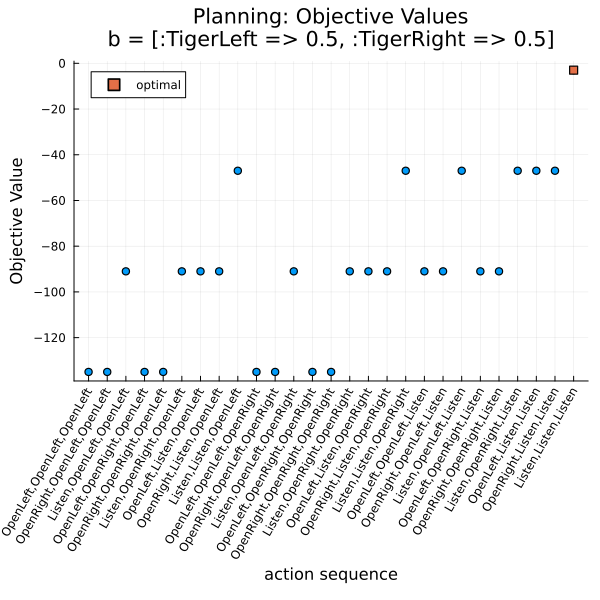

In [6]:
# Initial belief
b = POMDPTools.BeliefUpdaters.uniform_belief(tiger_pomdp)

# Define the belief updater
tiger_updater = DiscreteUpdater(tiger_pomdp)
L = 3

# Perform a single planning session and compare 
action_sequences = get_action_sequences(tiger_pomdp, L)
objective_values = [objective_function(tiger_pomdp, tiger_updater, b, a_seq) for a_seq in action_sequences]
max_index = argmax(objective_values)

x_ticks = [join(string.(a_seq),",") for a_seq in action_sequences]
opt_action_sequence = action_sequences[max_index]
@show opt_action_sequence
opt_objective_value = objective_values[max_index]

p = scatter(objective_values, xlabel="action sequence", xrotation = 60, xticks=(1:length(objective_values), x_ticks), ylabel="Objective Value", label=false, title="Planning: Objective Values\nb = $([s=> pdf(b, s) for s in support(b)])", size=(600,600))
scatter!(p, [max_index], [opt_objective_value], markershape=:square, label="optimal")

opt_action_sequence = [:OpenRight, :Listen, :Listen]


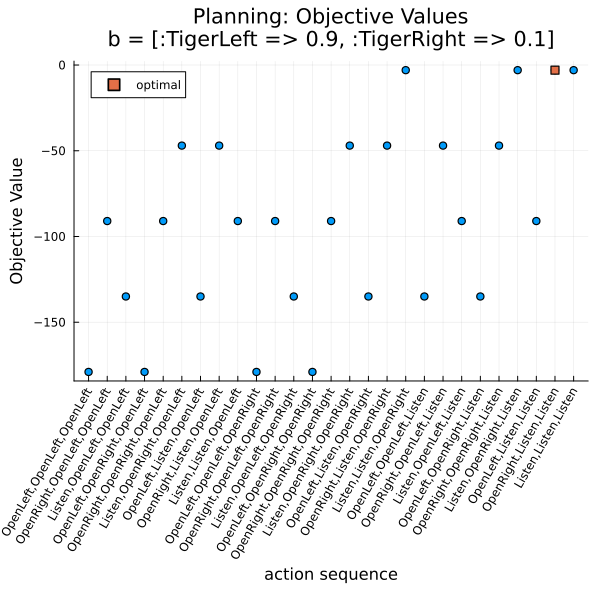

In [7]:
Random.seed!(0970252)

# Initial belief
b = DiscreteBelief(tiger_pomdp, [0.9, 0.1])

# Define the belief updater
tiger_updater = DiscreteUpdater(tiger_pomdp)
L = 3

action_sequences = get_action_sequences(tiger_pomdp, L)
objective_values = [objective_function(tiger_pomdp, tiger_updater, b, a_seq) for a_seq in action_sequences]
max_index = argmax(objective_values)

x_ticks = [join(string.(a_seq),",") for a_seq in action_sequences]
opt_action_sequence = action_sequences[max_index]
@show opt_action_sequence
opt_objective_value = objective_values[max_index]

p = scatter(objective_values, xlabel="action sequence", xrotation = 60, xticks=(1:length(objective_values), x_ticks), ylabel="Objective Value", label=false, title="Planning: Objective Values\nb = $([s=> pdf(b, s) for s in support(b)])", size=(600,600))
scatter!(p, [max_index], [opt_objective_value], markershape=:square, label="optimal")

In [8]:
Random.seed!(0970252)

# Initial belief
b = POMDPTools.BeliefUpdaters.uniform_belief(tiger_pomdp)
println("Initial belief: ", [s=> pdf(b, s) for s in support(b)])

# Define the belief updater
tiger_updater = DiscreteUpdater(tiger_pomdp)

# Initial state
s = :TigerRight

L = 3
T = 30

rs_tiger = []
r_cumul = 0.0
bs_tiger = []

# Perform a planning session every T time steps
t = 1
opt_open_loop_a = []
while t ≤ T
    if isempty(opt_open_loop_a)
        # Start a new planning session for L steps
        opt_open_loop_a, _ = open_loop_solver(tiger_pomdp, tiger_updater, b, L)
        @show opt_open_loop_a
    end
    a = popfirst!(opt_open_loop_a)
    sp, o, r = @gen(:sp, :o, :r)(tiger_pomdp, s, a)

    # Update the belief
    b = update(tiger_updater, b, a, o)
    b_dict = [s=>pdf(b,s) for s in support(b)]
    @show t, a, o, b_dict

    s = sp
    r_cumul += r
    t += 1
    push!(rs_tiger, r_cumul)
    push!(bs_tiger, b)
end

Initial belief: [:TigerLeft => 0.5, :TigerRight => 0.5]
opt_open_loop_a = [:Listen, :Listen, :Listen]
(t, a, o, b_dict) = (1, :Listen, :HearRight, [:TigerLeft => 0.15, :TigerRight => 0.85])
(t, a, o, b_dict) = (2, :Listen, :HearRight, [:TigerLeft => 0.0302013422818792, :TigerRight => 0.9697986577181208])
(t, a, o, b_dict) = (3, :Listen, :HearRight, [:TigerLeft => 0.005465587044534414, :TigerRight => 0.9945344129554656])
opt_open_loop_a = [:Listen, :Listen, :OpenLeft]
(t, a, o, b_dict) = (4, :Listen, :HearLeft, [:TigerLeft => 0.030201342281879203, :TigerRight => 0.9697986577181208])
(t, a, o, b_dict) = (5, :Listen, :HearRight, [:TigerLeft => 0.005465587044534414, :TigerRight => 0.9945344129554656])
(t, a, o, b_dict) = (6, :OpenLeft, :HearLeft, [:TigerLeft => 0.5, :TigerRight => 0.5])
opt_open_loop_a = [:Listen, :Listen, :Listen]
(t, a, o, b_dict) = (7, :Listen, :HearLeft, [:TigerLeft => 0.85, :TigerRight => 0.15])
(t, a, o, b_dict) = (8, :Listen, :HearLeft, [:TigerLeft => 0.969798657718

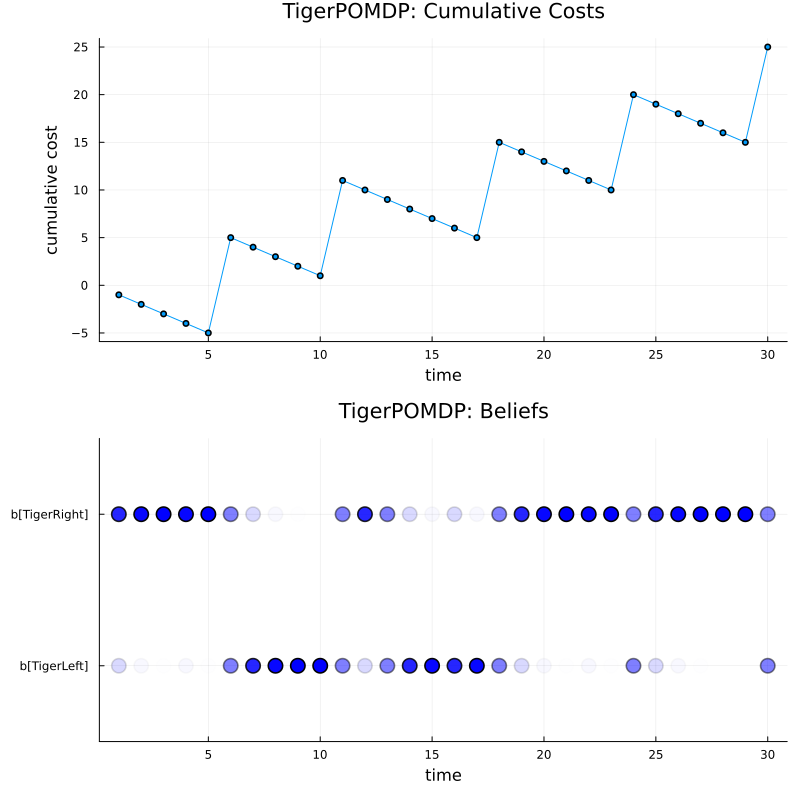

In [9]:
p1 = plot(1:T, rs_tiger, label=false, xlabel="time", ylabel="cumulative cost", markershape=:circle, markersize=3, title="TigerPOMDP: Cumulative Costs", size=(600,400))
p2 = plot(;xlabel="time", title="TigerPOMDP: Beliefs", ylims=[0,2], size=(800,200))
for s in states(tiger_pomdp)
    scatter!(p2, 1:T, fill("b[$(s)]",T), markershape=:circle, markersize=8, label = false, alpha=[pdf(b_t, s) for b_t in bs_tiger], color=:blue)
end
plot(p1,p2, layout=(2,1), size=(800,800))

### <img width="48" height="48" src="https://img.icons8.com/external-bearicons-outline-color-bearicons/64/external-copyright-graphic-design-bearicons-outline-color-bearicons.png" alt="external-copyright-graphic-design-bearicons-outline-color-bearicons"/> Credits

---

- Icons from [Icons8](https://icons8.com/)
- Belief Tree image from [Ye et al., 2017](https://arxiv.org/abs/1609.03250)
    - _"Despot: Online pomdp planning with regularization."_ by Ye, N., Somani, A., Hsu, D., and Lee, W. S. (2017). JAIR, 58:231–266.